In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import glob
import os
from neuroformer.SpikeVidUtils import trial_df, get_df_visnav, make_intervals, set_trials
import mat73
from neuroformer.SpikeVidUtils import make_intervals, round_n

In [2]:
medial_path = "./data/VisNav_VR_Expt/MedialVRDataset/df.csv"
lateral_path = "./data/VisNav_VR_Expt/LateralVRDataset/df.csv"
test_medial_path = "./data/VisNav_VR_Expt/MedialVRDataset/test_data.csv"
test_lateral_path = "./data/VisNav_VR_Expt/LateralVRDataset/test_data.csv"
df_medial = pd.read_csv(medial_path)
df_lateral = pd.read_csv(lateral_path)
df_medial_test = pd.read_csv(test_medial_path)
df_lateral_test = pd.read_csv(test_lateral_path)

In [3]:
dataset = "Lateral"
data_path = f"./data/VisNav_VR_Expt/{dataset}VRDataset/experiment_data.mat"
save_path = f"./results/behavior/{dataset}"
test_path = f"./data/VisNav_VR_Expt/{dataset}VRDataset/test_data.csv"
data = mat73.loadmat(data_path)['neuroformer']
behavior_vars = ['speed']

response = data['spiketimes']['spks']
trial_data = data['trialsummary']
# response = data_response['spiketime_sel2']['spks']

print(data.keys())
dt_vars = 0.05
df = get_df_visnav(response, trial_data, dt_vars)
# df = df[df['ID'].isin(neurons_sel1)].reset_index(drop=True)
df_behavior = pd.DataFrame({k: data[k] for k in behavior_vars + ['t']})
df_behavior.rename(columns={'t': 'Time'}, inplace=True)
df_behavior['Interval'] = make_intervals(df_behavior, 0.05)
df_behavior['raw_interval'] = make_intervals(df_behavior, 0.05)
df_behavior = set_trials(df_behavior, trial_data)
df = df_medial
df = set_trials(df, trial_data)
df['Interval'] = make_intervals(df, 0.05)
df_test = df_medial_test
# df_test['raw_interval'] = make_intervals(df_test, 0.05)
# df_test = set_trials(df_test, trial_data)
# df_test['Interval'] = make_intervals(df_test, 0.05)

# min/max df_behavior['speed'] values: (-1.5, 1.5)
# min/max df_behavior['speed'] values: (-1.5, 1.5)
# set min/max speed values to -1.5/1.5
df_behavior['speed'] = df_behavior['speed'].apply(lambda x: -2 if x < -2 else x)
df_behavior['speed'] = df_behavior['speed'].apply(lambda x: 2 if x > 2 else x)
df_behavior['speed'] = df_behavior['speed'].apply(lambda x: round_n(x, dt_vars))

dict_keys(['eyerad', 'phi', 'rewards', 'speed', 'spiketimes', 't', 'th', 'trialsummary', 'vid_sm'])


In [4]:
neuron_firing_times = data['spiketimes']['spks']
max_time = df_behavior['Interval'].max()
num_intervals = int(1505 / 0.05)
num_neurons = len(neuron_firing_times)

# Initialize a 2D array with zeros
firing_counts = np.zeros((num_intervals, num_neurons))

# Loop over each neuron
for i, neuron_times in enumerate(neuron_firing_times):
    neuron_times = neuron_times[0]
    # Convert firing times to interval indices
    interval_indices = (neuron_times / 0.05).astype(int)
    if np.isscalar(interval_indices):
        interval_indices = np.array([interval_indices])
    # Count the number of firings in each interval
    for index in interval_indices:
        # Ensure the index is within the range of intervals
        if 0 <= index < num_intervals:
            firing_counts[index, i] += 1

In [5]:
firing_counts_df = pd.DataFrame(firing_counts)
firing_counts_df['Interval'] = np.arange(0, 1505, 0.05)

In [6]:
firing_counts_df = firing_counts_df.merge(df_behavior, on='Interval', how='left').dropna().reset_index(drop=True)
firing_counts_df.columns = firing_counts_df.columns.astype(str) 

In [24]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr

target = 'speed'

# Assuming 'target' is the column in df_behavior which you want to predict
y = firing_counts_df[target]

# Drop the 'target' column from firing_counts_df to avoid leakage
X = firing_counts_df.drop(columns=[target])

# Feature scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into a training set and a test set
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=None)

# Initialize Lasso model
ALPHA = 0.01
lasso = Lasso(alpha=ALPHA)

# Define the k-fold cross validator
k = 10
kf = KFold(n_splits=k, random_state=None)

# Placeholders for metrics
r2_scores = []
rmse_scores = []
pearson_correlations = []

# Loop over each fold
for train_index, val_index in kf.split(X_train_full):
    X_train, X_val = X_train_full[train_index], X_train_full[val_index]
    y_train, y_val = y_train_full[train_index], y_train_full[val_index]
    
    # Fit the model to the training data
    lasso.fit(X_train, y_train)

    # Use the model to make predictions on the validation data
    predictions_val = lasso.predict(X_val)

    # Compute and append R^2 and RMSE for the validation set
    r2_scores.append(r2_score(y_val, predictions_val))
    rmse_scores.append(np.sqrt(mean_squared_error(y_val, predictions_val)))

    # Compute and append Pearson correlation for the validation set
    corr, _ = pearsonr(y_val, predictions_val)
    pearson_correlations.append(corr)

# Compute the average scores
mean_r2 = np.mean(r2_scores)
mean_rmse = np.mean(rmse_scores)
mean_corr = np.mean(pearson_correlations)
std_corr = np.std(pearson_correlations)

# Print the average scores
print('Average R^2 score: ', mean_r2)
print('Average RMSE: ', mean_rmse)
print('Average Pearsons correlation: ', mean_corr)

# Finally, you can evaluate the model on the test set
predictions_test = lasso.predict(X_test)
print('Test R^2 score: ', r2_score(y_test, predictions_test))
print('Test RMSE: ', np.sqrt(mean_squared_error(y_test, predictions_test)))
corr, _ = pearsonr(y_test, predictions_test)
print('Test Pearsons correlation: ', corr)

KeyError: '[1785, 1787, 1794, 1795, 1801, 1803, 1824, 1826, 1836, 1837, 1838, 1840, 1843, 1851, 1858, 1860, 1861, 1867, 1870, 1874, 1880, 1884, 1886, 1888, 1889, 1890, 1896, 1898, 1901, 1904, 1905, 1910, 1911, 1920, 1921, 1923, 1926, 1932, 1933, 1935, 1939, 1941, 1942, 1959, 1963, 1965, 1973, 1981, 1990, 1997, 1998, 2001, 2005, 2017, 2022, 2033, 2036, 2039, 2042, 2060, 2067, 2082, 2087, 2098, 2101, 2106, 2110, 2115, 2117, 2118, 2120, 2135, 2161, 2166, 2173, 2176, 2177, 2178, 2191, 2196, 2199, 2203, 2205, 2215, 2217, 2218, 2222, 2223, 2224, 2227, 2233, 2242, 2245, 2247, 2252, 2258, 2262, 2266, 2289, 2291, 2297, 2309, 2311, 2314, 2316, 2317, 2326, 2327, 2337, 2344, 2346, 2347, 2351, 2365, 2368, 2371, 2388, 2396, 2406, 2411, 2415, 2422, 2424, 2427, 2436, 2437, 2439, 2441, 2442, 2445, 2446, 2451, 2453, 2460, 2461, 2465, 2474, 2477, 2480, 2482, 2483, 2485, 2502, 2513, 2514, 2517, 2522, 2526, 2527, 2531, 2538, 2539, 2542, 2560, 2583, 2589, 2599, 2601, 2609, 2616, 2617, 2618, 2622, 2629, 2632, 2636, 2645, 2650, 2652, 2659, 2662, 2676, 2681, 2682, 2686, 2691, 2693, 2697, 2701, 2706, 2715, 2718, 2723, 2726, 2727, 2731, 2738, 2745, 2765, 2766, 2782, 2786, 2793, 2797, 2806, 2807, 2816, 2821, 2825, 2828, 2829, 2838, 2839, 2841, 2848, 2862, 2865, 2869, 2874, 2881, 2882, 2888, 2891, 2893, 2895, 2897, 2900, 2904, 2917, 2919, 2922, 2926, 2933, 2935, 2941, 2948, 2951, 2952, 2953, 2956, 2959, 2962, 2965, 2967, 2976, 2978, 2979, 2984, 2988, 2991, 2997, 3002, 3015, 3020, 3021, 3039, 3040, 3042, 3048, 3051, 3053, 3059, 3060, 3070, 3073, 3080, 3082, 3085, 3087, 3090, 3094, 3097, 3103, 3108, 3115, 3116, 3121, 3123, 3127, 3129, 3130, 3133, 3134, 3142, 3149, 3158, 3164, 3167, 3172, 3179, 3185, 3191, 3196, 3199, 3215, 3216, 3227, 3231, 3236, 3237, 3249, 3252, 3264, 3272, 3273, 3274, 3277, 3291, 3300, 3314, 3317, 3318, 3337, 3341, 3344, 3347, 3363, 3367, 3368, 3373, 3376, 3379, 3384, 3416, 3429, 3432, 3433, 3436, 3437, 3438, 3443, 3445, 3450, 3454, 3456, 3459, 3461, 3463, 3466, 3468, 3473, 3474, 3475, 3479, 3486, 3494, 3497, 3504, 3505, 3508, 3512, 3519, 3523, 3525, 3527, 3529, 3532, 3538, 3545, 3546, 3551, 3560, 3562, 3563, 3573, 3574, 3576, 3577, 3584, 3589, 3590, 3596, 3598, 3599, 3601, 3610, 3611, 3629, 3638, 3643, 3645, 3649, 3656, 3657, 3672, 3674, 3675, 3679, 3689, 3694, 3698, 3704, 3706, 3707, 3713, 3718, 3721, 3724, 3729, 3732, 3733, 3738, 3743, 3748, 3754, 3764, 3765, 3767, 3773, 3775, 3776, 3780, 3784, 3787, 3792, 3794, 3797, 3799, 3800, 3808, 3811, 3814, 3822, 3831, 3835, 3840, 3851, 3861, 3867, 3874, 3877, 3885, 3901, 3907, 3911, 3915, 3918, 3924, 3929, 3930, 3942, 3945, 3952, 3958, 3960, 3963, 3968, 3969, 3977, 4000, 4003, 4008, 4011, 4021, 4024, 4029, 4047, 4049, 4063, 4070, 4074, 4075, 4076, 4085, 4087, 4090, 4094, 4101, 4120, 4129, 4138, 4140, 4148, 4151, 4154, 4155, 4163, 4174, 4183, 4188, 4203, 4204, 4214, 4224, 4228, 4234, 4241, 4249, 4252, 4260, 4262, 4263, 4267, 4269, 4271, 4282, 4283, 4284, 4285, 4288, 4306, 4316, 4318, 4321, 4324, 4331, 4332, 4336, 4339, 4349, 4351, 4357, 4363, 4370, 4371, 4375, 4379, 4380, 4383, 4384, 4386, 4388, 4404, 4407, 4411, 4412, 4414, 4422, 4427, 4428, 4430, 4460, 4466, 4469, 4475, 4479, 4480, 4482, 4488, 4498, 4503, 4508, 4509, 4510, 4511, 4514, 4517, 4519, 4525, 4528, 4530, 4533, 4535, 4541, 4553, 4557, 4561, 4567, 4569, 4573, 4575, 4576, 4579, 4591, 4592, 4594, 4595, 4600, 4604, 4611, 4620, 4627, 4631, 4636, 4638, 4646, 4648, 4650, 4652, 4653, 4654, 4658, 4665, 4690, 4692, 4700, 4706, 4709, 4710, 4726, 4732, 4744, 4745, 4746, 4751, 4753, 4756, 4763, 4766, 4768, 4779, 4780, 4784, 4792, 4799, 4801, 4814, 4822, 4823, 4831, 4832, 4836, 4842, 4856, 4865, 4897, 4898, 4900, 4902, 4912, 4916, 4942, 4944, 4947, 4948, 4951, 4955, 4956, 4964, 4965, 4971, 4980, 4981, 4984, 4992, 4994, 5000, 5001, 5004, 5007, 5008, 5016, 5018, 5021, 5028, 5044, 5045, 5047, 5052, 5064, 5071, 5073, 5074, 5078, 5079, 5081, 5086, 5097, 5105, 5107, 5115, 5119, 5121, 5124, 5136, 5138, 5143, 5156, 5165, 5168, 5170, 5171, 5177, 5183, 5184, 5188, 5189, 5195, 5214, 5215, 5219, 5227, 5232, 5233, 5236, 5237, 5245, 5251, 5252, 5253, 5256, 5257, 5260, 5276, 5277, 5282, 5285, 5295, 5297, 5316, 5322, 5324, 5329, 5332, 5343, 5346, 5347, 5350, 5352, 5357, 5358, 5364, 5368, 5371, 5372, 5373, 5383, 5389, 5391, 5393, 5395, 5396, 5402, 5404, 5416, 5432, 5433, 5444, 5455, 5459, 5475, 5476, 5477, 5480, 5488, 5494, 5495, 5499, 5508, 5512, 5526, 5527, 5534, 5540, 5542, 5547, 5551, 5552, 5555, 5557, 5563, 5566, 5569, 5580, 5596, 5604, 5609, 5613, 5615, 5619, 5627, 5633, 5634, 5636, 5637, 5638, 5641, 5649, 5652, 5653, 5657, 5658, 5660, 5680, 5685, 5690, 5691, 5693, 5694, 5712, 5719, 5720, 5722, 5723, 5739, 5745, 5759, 5768, 5773, 5785, 5786, 5789, 5790, 5792, 5810, 5814, 5815, 5826, 5847, 5848, 5851, 5854, 5855, 5862, 5865, 5882, 5891, 5898, 5899, 5902, 5913, 5919, 5921, 5924, 5930, 5941, 5944, 5946, 5949, 5954, 5955, 5960, 5967, 5973, 5977, 5979, 5980, 5992, 6000, 6001, 6017, 6019, 6036, 6041, 6051, 6052, 6054, 6095, 6096, 6098, 6101, 6107, 6111, 6119, 6128, 6130, 6135, 6136, 6144, 6151, 6153, 6156, 6159, 6162, 6163, 6180, 6183, 6185, 6193, 6206, 6208, 6210, 6215, 6217, 6219, 6223, 6226, 6237, 6239, 6242, 6243, 6249, 6251, 6255, 6259, 6267, 6268, 6281, 6285, 6290, 6298, 6300, 6314, 6316, 6322, 6323, 6340, 6345, 6349, 6351, 6352, 6353, 6354, 6355, 6359, 6360, 6362, 6369, 6373, 6374, 6377, 6379, 6386, 6395, 6396, 6398, 6405, 6409, 6414, 6416, 6423, 6444, 6446, 6448, 6453, 6462, 6466, 6469, 6480, 6482, 6484, 6485, 6488, 6502, 6508, 6514, 6520, 6523, 6539, 6544, 6545, 6548, 6554, 6556, 6558, 6562, 6568, 6575, 6578, 6582, 6595, 6596, 6599, 6603, 6604, 6612, 6613, 6617, 6627, 6628, 6632, 6640, 6641, 6644, 6646, 6651, 6652, 6654, 6659, 6660, 6662, 6663, 6665, 6667, 6676, 6677, 6679, 6680, 6685, 6687, 6690, 6691, 6704, 6706, 6707, 6715, 6716, 6724, 6725, 6726, 6728, 6729, 6739, 6742, 6743, 6751, 6753, 6758, 6763, 6764, 6765, 6775, 6778, 6779, 6788, 6793, 6794, 6796, 6807, 6810, 6818, 6822, 6824, 6828, 6829, 6834, 6838, 6843, 6846, 6853, 6857, 6864, 6865, 6875, 6890, 6897, 6903, 6904, 6905, 6907, 6908, 6910, 6911, 6916, 6917, 6919, 6920, 6925, 6926, 6931, 6940, 6945, 6953, 6956, 6961, 6963, 6964, 6986, 6988, 6990, 6997, 6999, 7000, 7007, 7015, 7016, 7017, 7025, 7032, 7034, 7035, 7037, 7038, 7044, 7046, 7050, 7054, 7064, 7065, 7068, 7075, 7088, 7098, 7105, 7112, 7113, 7114, 7117, 7120, 7126, 7129, 7131, 7139, 7148, 7149, 7155, 7160, 7161, 7164, 7180, 7189, 7194, 7203, 7208, 7210, 7220, 7225, 7228, 7231, 7234, 7235, 7244, 7249, 7252, 7254, 7259, 7260, 7262, 7266, 7271, 7279, 7280, 7283, 7285, 7286, 7288, 7290, 7292, 7294, 7306, 7318, 7320, 7321, 7328, 7333, 7345, 7347, 7350, 7352, 7363, 7364, 7367, 7371, 7379, 7387, 7390, 7395, 7401, 7402, 7403, 7406, 7411, 7417, 7419, 7434, 7437, 7443, 7448, 7455, 7458, 7471, 7473, 7483, 7486, 7492, 7498, 7500, 7501, 7503, 7504, 7508, 7509, 7517, 7519, 7522, 7524, 7532, 7546, 7548, 7553, 7556, 7560, 7562, 7573, 7579, 7581, 7585, 7586, 7604, 7617, 7622, 7629, 7635, 7636, 7643, 7644, 7649, 7652, 7659, 7666, 7670, 7681, 7683, 7699, 7700, 7709, 7711, 7713, 7722, 7723, 7728, 7733, 7738, 7739, 7746, 7749, 7755, 7756, 7760, 7771, 7774, 7792, 7800, 7802, 7803, 7814, 7824, 7825, 7827, 7828, 7833, 7836, 7838, 7857, 7867, 7868, 7871, 7874, 7876, 7883, 7891, 7895, 7900, 7901, 7907, 7911, 7916, 7922, 7930, 7931, 7937, 7949, 7953, 7958, 7971, 7977, 7982, 7988, 7994, 7997, 8007, 8011, 8017, 8026, 8027, 8035, 8036, 8037, 8055, 8060, 8065, 8066, 8070, 8074, 8077, 8080, 8086, 8088, 8091, 8094, 8096, 8099, 8105, 8106, 8107, 8121, 8125, 8129, 8132, 8139, 8146, 8152, 8154, 8159, 8162, 8163, 8167, 8169, 8180, 8181, 8185, 8187, 8191, 8192, 8196, 8197, 8204, 8219, 8223, 8224, 8235, 8238, 8241, 8244, 8249, 8251, 8255, 8265, 8270, 8277, 8290, 8298, 8299, 8301, 8303, 8307, 8312, 8313, 8327, 8330, 8334, 8335, 8342, 8344, 8345, 8351, 8354, 8355, 8364, 8365, 8369, 8371, 8375, 8391, 8393, 8401, 8407, 8408, 8415, 8421, 8424, 8429, 8447, 8450, 8451, 8452, 8454, 8462, 8468, 8471, 8520, 8522, 8523, 8526, 8539, 8547, 8564, 8570, 8576, 8587, 8599, 8601, 8604, 8632, 8643, 8645, 8652, 8660, 8662, 8663, 8667, 8684, 8693, 8703, 8707, 8709, 8714, 8720, 8722, 8728, 8729, 8734, 8735, 8737, 8740, 8743, 8744, 8745, 8748, 8749, 8750, 8760, 8767, 8784, 8787, 8789, 8794, 8801, 8804, 8805, 8819, 8820, 8823, 8829, 8831, 8833, 8844, 8846, 8858, 8878, 8880, 8881, 8882, 8886, 8891, 8894, 8895, 8896, 8904, 8909, 8910, 8920, 8921, 8923, 8929, 8934, 8935, 8936, 8940, 8944, 8950, 8954, 8958, 8964, 8969, 8976, 8979, 8987, 8990, 8995, 8999, 9000, 9006, 9009, 9021, 9022, 9029, 9030, 9032, 9041, 9047, 9049, 9058, 9061, 9063, 9068, 9074, 9087, 9089, 9091, 9095, 9098, 9107, 9120, 9123, 9126, 9135, 9141, 9147, 9148, 9149, 9156, 9168, 9176, 9177, 9184, 9198, 9201, 9209, 9212, 9213, 9230, 9231, 9233, 9235, 9237, 9238, 9239, 9255, 9260, 9271, 9274, 9276, 9283, 9289, 9295, 9301, 9307, 9308, 9310, 9313, 9315, 9316, 9338, 9341, 9346, 9354, 9360, 9361, 9389, 9402, 9405, 9413, 9421, 9422, 9429, 9430, 9431, 9433, 9434, 9436, 9437, 9438, 9449, 9450, 9458, 9462, 9496, 9497, 9503, 9526, 9528, 9529, 9535, 9537, 9546, 9549, 9558, 9561, 9565, 9570, 9573, 9582, 9584, 9586, 9588, 9592, 9593, 9595, 9599, 9602, 9605, 9606, 9611, 9614, 9615, 9616, 9620, 9622, 9630, 9634, 9644, 9648, 9649, 9650, 9651, 9662, 9673, 9674, 9675, 9677, 9684, 9685, 9686, 9687, 9689, 9693, 9694, 9695, 9696, 9698, 9731, 9734, 9740, 9741, 9743, 9745, 9752, 9766, 9775, 9778, 9782, 9788, 9795, 9798, 9799, 9806, 9811, 9812, 9814, 9815, 9817, 9819, 9821, 9827, 9832, 9833, 9836, 9841, 9846, 9850, 9854, 9857, 9859, 9861, 9864, 9868, 9876, 9878, 9879, 9889, 9890, 9893, 9900, 9902, 9915, 9919, 9927, 9929, 9945, 9953, 9965, 9966, 9973, 9979, 9986, 9988, 10003, 10005, 10010, 10019, 10030, 10034, 10035, 10037, 10043, 10060, 10067, 10075, 10077, 10079, 10091, 10093, 10102, 10108, 10111, 10114, 10118, 10120, 10121, 10126, 10128, 10135, 10140, 10151, 10152, 10153, 10155, 10163, 10172, 10177, 10188, 10193, 10195, 10198, 10211, 10216, 10219, 10229, 10232, 10234, 10243, 10264, 10273, 10274, 10276, 10283, 10284, 10286, 10290, 10292, 10295, 10298, 10301, 10302, 10306, 10307, 10309, 10310, 10317, 10324, 10325, 10327, 10329, 10334, 10335, 10341, 10342, 10345, 10350, 10352, 10354, 10369, 10378, 10390, 10393, 10405, 10407, 10409, 10415, 10417, 10418, 10424, 10425, 10433, 10446, 10449, 10458, 10466, 10467, 10470, 10474, 10481, 10488, 10509, 10510, 10514, 10515, 10527, 10528, 10529, 10534, 10545, 10549, 10550, 10553, 10555, 10563, 10564, 10566, 10569, 10571, 10573, 10575, 10589, 10599, 10601, 10607, 10612, 10619, 10622, 10626, 10631, 10632, 10642, 10644, 10650, 10652, 10654, 10660, 10663, 10665, 10666, 10672, 10677, 10678, 10680, 10691, 10697, 10714, 10717, 10718, 10720, 10721, 10729, 10732, 10742, 10747, 10751, 10764, 10775, 10776, 10778, 10779, 10782, 10784, 10794, 10799, 10800, 10803, 10806, 10807, 10814, 10826, 10829, 10834, 10836, 10837, 10839, 10841, 10844, 10846, 10850, 10852, 10866, 10869, 10870, 10874, 10878, 10883, 10885, 10886, 10889, 10893, 10900, 10904, 10905, 10911, 10915, 10918, 10921, 10924, 10930, 10931, 10933, 10937, 10943, 10946, 10948, 10960, 10965, 10967, 10970, 10971, 10973, 10990, 10992, 10995, 10997, 11005, 11008, 11009, 11010, 11013, 11014, 11025, 11041, 11050, 11059, 11065, 11069, 11074, 11075, 11079, 11085, 11086, 11098, 11103, 11105, 11113, 11115, 11142, 11146, 11147, 11148, 11158, 11163, 11166, 11170, 11172, 11173, 11198, 11201, 11211, 11212, 11213, 11220, 11222, 11236, 11237, 11241, 11244, 11247, 11252, 11261, 11266, 11270, 11274, 11277, 11279, 11283, 11284, 11285, 11287, 11288, 11289, 11297, 11301, 11302, 11307, 11309, 11312, 11319, 11324, 11331, 11332, 11336, 11337, 11341, 11344, 11345, 11363, 11366, 11372, 11380, 11385, 11386, 11389, 11390, 11391, 11392, 11395, 11403, 11407, 11415, 11416, 11456, 11457, 11461, 11463, 11465, 11468, 11472, 11473, 11475, 11482, 11490, 11494, 11498, 11504, 11505, 11508, 11514, 11516, 11523, 11525, 11527, 11529, 11533, 11541, 11545, 11547, 11550, 11567, 11577, 11579, 11581, 11583, 11584, 11586, 11587, 11601, 11602, 11603, 11606, 11616, 11624, 11625, 11626, 11628, 11643, 11645, 11647, 11655, 11656, 11659, 11661, 11663, 11666, 11670, 11675, 11677, 11686, 11689, 11690, 11691, 11693, 11704, 11711, 11719, 11720, 11722, 11726, 11728, 11731, 11734, 11747, 11751, 11754, 11755, 11760, 11763, 11765, 11766, 11769, 11775, 11779, 11788, 11791, 11800, 11801, 11802, 11803, 11804, 11805, 11812, 11815, 11822, 11825, 11830, 11842, 11843, 11851, 11853, 11856, 11857, 11873, 11875, 11881, 11899, 11915, 11916, 11922, 11930, 11932, 11934, 11942, 11949, 11952, 11954, 11958, 11959, 11964, 11968, 11974, 11975, 11978, 11979, 11986, 11988, 11993, 11997, 12006, 12007, 12012, 12017, 12018, 12020, 12022, 12027, 12029, 12030, 12031, 12040, 12042, 12052, 12054, 12063, 12070, 12071, 12072, 12073, 12079, 12086, 12091, 12093, 12099, 12100, 12104, 12112, 12122, 12126, 12130, 12131, 12133, 12138, 12148, 12152, 12161, 12165, 12176, 12177, 12180, 12183, 12187, 12198, 12207, 12209, 12210, 12211, 12214, 12215, 12225, 12229, 12238, 12257, 12264, 12267, 12275, 12276, 12277, 12281, 12289, 12293, 12296, 12297, 12308, 12309, 12312, 12313, 12322, 12330, 12342, 12344, 12349, 12350, 12352, 12357, 12367, 12369, 12370, 12372, 12377, 12383, 12396, 12401, 12414, 12416, 12418, 12421, 12424, 12433, 12439, 12457, 12464, 12469, 12471, 12472, 12473, 12480, 12493, 12496, 12501, 12503, 12507, 12508, 12519, 12521, 12525, 12527, 12543, 12545, 12546, 12555, 12557, 12562, 12565, 12570, 12578, 12587, 12593, 12599, 12602, 12614, 12620, 12622, 12624, 12625, 12626, 12634, 12637, 12638, 12653, 12660, 12669, 12671, 12672, 12676, 12684, 12690, 12694, 12695, 12710, 12713, 12714, 12721, 12722, 12725, 12727, 12729, 12731, 12740, 12742, 12743, 12744, 12747, 12754, 12755, 12756, 12757, 12760, 12765, 12773, 12774, 12779, 12781, 12786, 12792, 12796, 12797, 12804, 12812, 12816, 12828, 12834, 12842, 12843, 12846, 12847, 12866, 12879, 12888, 12899, 12901, 12906, 12912, 12915, 12920, 12922, 12924, 12925, 12927, 12930, 12945, 12949, 12962, 12971, 12973, 12978, 12986, 12990, 12992, 13011, 13012, 13020, 13021, 13027, 13031, 13035, 13047, 13049, 13052, 13056, 13067, 13073, 13077, 13085, 13088, 13089, 13091, 13095, 13096, 13098, 13107, 13111, 13113, 13129, 13134, 13135, 13136, 13140, 13147, 13159, 13166, 13182, 13184, 13188, 13191, 13192, 13193, 13199, 13212, 13214, 13219, 13226, 13239, 13243, 13254, 13255, 13257, 13261, 13271, 13272, 13275, 13276, 13284, 13289, 13291, 13292, 13295, 13296, 13299, 13305, 13309, 13310, 13311, 13312, 13321, 13322, 13323, 13327, 13334, 13337, 13343, 13344, 13350, 13357, 13359, 13363, 13365, 13369, 13371, 13375, 13380, 13382, 13383, 13385, 13394, 13406, 13409, 13416, 13417, 13419, 13420, 13433, 13437, 13442, 13448, 13454, 13462, 13463, 13464, 13465, 13466, 13475, 13476, 13477, 13487, 13500, 13503, 13505, 13508, 13523, 13526, 13528, 13534, 13546, 13547, 13549, 13555, 13558, 13560, 13561, 13566, 13573, 13574, 13579, 13583, 13585, 13596, 13603, 13604, 13605, 13616, 13618, 13632, 13643, 13648, 13650, 13656, 13659, 13666, 13670, 13671, 13677, 13684, 13693, 13698, 13700, 13711, 13712, 13713, 13716, 13719, 13722, 13727, 13733, 13740, 13742, 13746, 13763, 13764, 13785, 13791, 13809, 13820, 13821, 13825, 13827, 13828, 13832, 13836, 13840, 13843, 13845, 13849, 13853, 13857, 13859, 13860, 13865, 13866, 13872, 13882, 13889, 13890, 13893, 13895, 13896, 13897, 13899, 13901, 13904, 13905, 13911, 13912, 13920, 13927, 13931, 13933, 13934, 13943, 13944, 13947, 13948, 13952, 13954, 13971, 13976, 13977, 13989, 13993, 13997, 14000, 14004, 14014, 14020, 14021, 14027, 14035, 14038, 14039, 14040, 14052, 14056, 14059, 14064, 14070, 14071, 14075, 14085, 14089, 14098, 14105, 14113, 14116, 14125, 14126, 14138, 14139, 14147, 14149, 14152, 14157, 14159, 14163, 14167, 14169, 14181, 14183, 14186, 14192, 14196, 14205, 14211, 14212, 14215, 14216, 14217, 14220, 14223, 14238, 14241, 14242, 14251, 14254, 14258, 14262, 14265, 14267, 14268, 14269, 14271, 14272, 14278, 14283, 14284, 14285, 14286, 14289, 14293, 14295, 14296, 14298, 14300, 14303, 14304, 14305, 14307, 14308, 14311, 14319, 14321, 14324, 14328, 14329, 14330, 14336, 14337, 14347, 14357, 14359, 14368, 14371, 14374, 14377, 14378, 14379, 14386, 14389, 14406, 14413, 14420, 14425, 14433, 14440, 14447, 14465, 14466, 14467, 14477, 14485, 14487, 14489, 14491, 14508, 14513, 14516, 14519, 14520, 14524, 14532, 14534, 14551, 14556, 14558, 14583, 14589, 14590, 14597, 14603, 14609, 14626, 14629, 14630, 14641, 14646, 14651, 14677, 14679, 14680, 14695, 14696, 14699, 14705, 14707, 14717, 14718, 14728, 14734, 14736, 14739, 14743, 14746, 14748, 14751, 14761, 14763, 14770, 14794, 14798, 14806, 14816, 14821, 14824, 14825, 14835, 14841, 14842, 14850, 14853, 14854, 14863, 14866, 14869, 14870, 14874, 14878, 14884, 14885, 14892, 14897, 14904, 14906, 14914, 14916, 14923, 14928, 14934, 14935, 14939, 14940, 14944, 14945, 14949, 14951, 14954, 14955, 14960, 14961, 14983, 14985, 14990, 15003, 15018, 15021, 15022, 15024, 15026, 15028, 15031, 15037, 15038, 15047, 15057, 15066, 15075, 15077, 15079, 15080, 15081, 15082, 15084, 15086, 15088, 15090, 15096, 15098, 15102, 15106, 15124, 15129, 15133, 15135, 15146, 15149, 15154, 15159, 15171, 15197, 15200, 15201, 15214, 15218, 15224, 15226, 15232, 15239, 15241, 15242, 15251, 15252, 15253, 15259, 15263, 15267, 15271, 15272, 15274, 15279, 15281, 15284, 15285, 15287, 15288, 15290, 15292, 15297, 15309, 15310, 15311, 15313, 15325, 15326, 15333, 15334, 15335, 15337, 15342, 15346, 15349, 15356, 15357, 15365, 15375, 15380, 15399, 15406, 15411, 15417, 15418, 15419, 15427, 15430, 15433, 15443, 15447, 15448, 15451, 15473, 15475, 15478, 15485, 15486, 15491, 15494, 15495, 15498, 15502, 15505, 15510, 15511, 15514, 15523, 15525, 15535, 15540, 15544, 15546, 15547, 15556, 15557, 15558, 15560, 15567, 15568, 15569, 15570, 15579, 15582, 15588, 15590, 15592, 15603, 15605, 15611, 15617, 15623, 15625, 15628, 15634, 15637, 15639, 15653, 15654, 15656, 15659, 15668, 15692, 15695, 15700, 15702, 15705, 15707, 15717, 15720, 15730, 15731, 15734, 15738, 15742, 15745, 15751, 15755, 15756, 15761, 15768, 15776, 15779, 15781, 15786, 15790, 15799, 15803, 15808, 15812, 15818, 15821, 15822, 15823, 15842, 15844, 15845, 15847, 15856, 15861, 15864, 15881, 15884, 15887, 15896, 15913, 15931, 15934, 15935, 15939, 15946, 15951, 15955, 15956, 15963, 15968, 15969, 15981, 15982, 15985, 15988, 15997, 16002, 16009, 16014, 16019, 16034, 16052, 16055, 16063, 16065, 16069, 16070, 16079, 16083, 16087, 16096, 16103, 16104, 16106, 16109, 16116, 16120, 16122, 16124, 16130, 16131, 16133, 16134, 16140, 16147, 16151, 16158, 16166, 16171, 16186, 16190, 16193, 16195, 16205, 16213, 16215, 16225, 16227, 16230, 16245, 16248, 16252, 16254, 16259, 16263, 16264, 16274, 16277, 16283, 16285, 16287, 16307, 16329, 16330, 16331, 16335, 16337, 16356, 16357, 16367, 16369, 16376, 16377, 16381, 16382, 16383, 16385, 16387, 16388, 16390, 16392, 16403, 16412, 16414, 16417, 16424, 16430, 16431, 16434, 16440, 16441, 16444, 16447, 16448, 16451, 16452, 16453, 16457, 16460, 16469, 16479, 16487, 16505, 16512, 16515, 16518, 16521, 16523, 16527, 16529, 16531, 16533, 16543, 16544, 16546, 16562, 16570, 16573, 16575, 16580, 16581, 16586, 16595, 16601, 16604, 16605, 16612, 16616, 16617, 16621, 16622, 16630, 16638, 16639, 16641, 16649, 16651, 16662, 16664, 16668, 16671, 16676, 16677, 16679, 16683, 16684, 16686, 16690, 16693, 16695, 16701, 16708, 16721, 16724, 16738, 16739, 16741, 16749, 16759, 16765, 16766, 16767, 16777, 16781, 16786, 16796, 16801, 16802, 16806, 16808, 16814, 16825, 16832, 16839, 16845, 16848, 16854, 16869, 16874, 16885, 16886, 16891, 16893, 16894, 16908, 16915, 16919, 16937, 16941, 16949, 16950, 16955, 16956, 16958, 16961, 16964, 16965, 16972, 16984, 16985, 16996, 17001, 17004, 17009, 17010, 17012, 17018, 17019, 17025, 17026, 17027, 17031, 17038, 17040, 17041, 17052, 17059, 17060, 17068, 17071, 17074, 17083, 17089, 17099, 17103, 17114, 17115, 17124, 17125, 17143, 17144, 17153, 17154, 17156, 17157, 17166, 17168, 17176, 17185, 17189, 17192, 17197, 17202, 17209, 17211, 17217, 17227, 17231, 17233, 17237, 17247, 17249, 17250, 17251, 17260, 17266, 17267, 17268, 17271, 17273, 17274, 17279, 17282, 17285, 17292, 17293, 17295, 17301, 17302, 17309, 17314, 17320, 17325, 17327, 17337, 17339, 17340, 17349, 17363, 17366, 17368, 17375, 17381, 17385, 17388, 17389, 17396, 17397, 17398, 17402, 17403, 17404, 17419, 17423, 17426, 17428, 17430, 17433, 17437, 17439, 17441, 17445, 17446, 17458, 17460, 17464, 17467, 17472, 17474, 17482, 17509, 17514, 17517, 17533, 17535, 17549, 17554, 17556, 17559, 17560, 17561, 17565, 17567, 17572, 17582, 17593, 17599, 17608, 17614, 17616, 17618, 17622, 17623, 17625, 17628, 17631, 17645, 17651, 17655, 17657, 17661, 17665, 17670, 17671, 17673, 17676, 17678, 17683, 17692, 17695, 17702, 17704, 17706, 17714, 17723, 17732, 17733, 17739, 17746, 17750, 17751, 17756, 17761, 17762, 17775, 17780, 17781, 17793, 17795, 17797, 17804, 17811, 17818, 17824, 17826, 17834, 17836, 17838] not in index'

Text(0.4463623009100056, 4.4625, 'Std: 0.07')

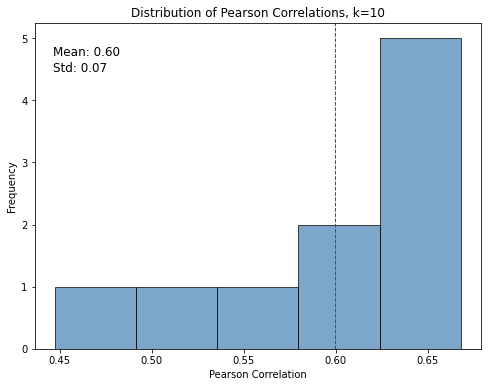

In [21]:
# Plot the distribution of Pearson correlations
plt.figure(figsize=(8, 6))
plt.hist(pearson_correlations, bins='auto', alpha=0.7, color='steelblue', edgecolor='black')
plt.title(f'Distribution of Pearson Correlations, k={k}')
plt.xlabel('Pearson Correlation')
plt.ylabel('Frequency')

# Overlay mean and std on the plot
plt.axvline(mean_corr, color='red', linestyle='dashed', linewidth=1)

# Get the limits of x and y axes
xlim = plt.xlim()
ylim = plt.ylim()

# Position the text at the top left corner
plt.text(xlim[0] + 0.01, ylim[1] - (ylim[1] - ylim[0]) * 0.1, f'Mean: {mean_corr:.2f}', fontsize=12)
plt.text(xlim[0] + 0.01, ylim[1] - (ylim[1] - ylim[0]) * 0.15, f'Std: {std_corr:.2f}', fontsize=12)


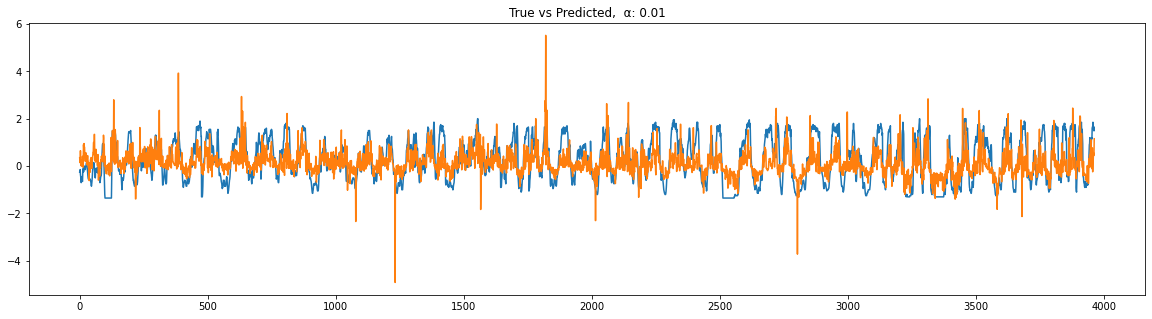

In [42]:
# plot true and predicted
x_axis = np.arange(len(y_test))

plt.figure(figsize=(20, 5))
plt.title(f'True vs Predicted,  α: {ALPHA}')
plt.plot(x_axis, y_test, label='True')
plt.plot(x_axis, predictions, label='Predicted')

In [39]:
df_predictions = pd.DataFrame({'behavior': predictions, 'true': y_test, 'Interval': firing_counts_df[firing_counts_df['Trial'].isin(test_trials)]['Interval']})

# save_path
df_predictions.to_csv(save_path + "/lasso_behavior.csv", index=False)

In [129]:
import statsmodels.api as sm

# for poisson first make sure target is non-negative
firing_counts_df_glm = firing_counts_df.copy()
# firing_counts_df_glm['speed'] += firing_counts_df_glm['speed'].min() + 1

y = firing_counts_df_glm[target]

# Drop the 'target' column from firing_counts_df to avoid leakage
X = firing_counts_df_glm.drop(columns=[target])

X_train_glm = X[firing_counts_df_glm['Trial'].isin(train_trials)]
X_test_glm = X[firing_counts_df_glm['Trial'].isin(test_trials)]
y_train_glm = y[firing_counts_df_glm['Trial'].isin(train_trials)]
y_test_glm = y[firing_counts_df_glm['Trial'].isin(test_trials)]

# Define the GLM model, assuming a Gaussian distribution
model = sm.GLM(y, X, family=sm.families.Gaussian())

# Fit the model
results = model.fit()

# Use the model to make predictions on the test data
predictions = results.predict(X_test_glm)

# Print the model summary
print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  speed   No. Observations:                22305
Model:                            GLM   Df Residuals:                    20281
Model Family:                Gaussian   Df Model:                         2023
Link Function:               Identity   Scale:                         0.47559
Method:                          IRLS   Log-Likelihood:                -22300.
Date:                Wed, 24 May 2023   Deviance:                       9645.4
Time:                        10:04:38   Pearson chi2:                 9.65e+03
No. Iterations:                   100   Pseudo R-squ. (CS):             0.6815
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
0                0.1029      0.040      2.599   

In [130]:
df_predictions_glm = pd.DataFrame({'behavior': predictions, 'true': y_test_glm, 'Interval': firing_counts_df_glm[firing_counts_df_glm['Trial'].isin(test_trials)]['Interval']})
df_predictions_glm.to_csv(save_path + "/glm_behavior.csv", index=False)

In [131]:
pearsonr(y_test_glm, predictions)

PearsonRResult(statistic=0.6796072855580902, pvalue=0.0)

In [132]:
y_test_glm

106     -0.25
107     -0.20
108     -0.15
109     -0.35
110     -0.45
         ... 
20921    1.70
20922    1.65
20923    1.50
20924    1.65
20925    1.50
Name: speed, Length: 3963, dtype: float64

In [133]:
print(sum(firing_counts_df.isnull().sum()))

0


In [134]:
print("Zero or negative values in response variable: ", (firing_counts_df['speed'] <= 0).sum())

Zero or negative values in response variable:  11596
